# Hyper-parameter tuning process simulation

#### Model: Random Forest
#### Hyper-parameter: "n_estimator", "max_depth"
#### data: iris

- - -
## 0. Setting

### Data

In [6]:
%matplotlib inline

import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from random import *

import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default = "notebook_connected"

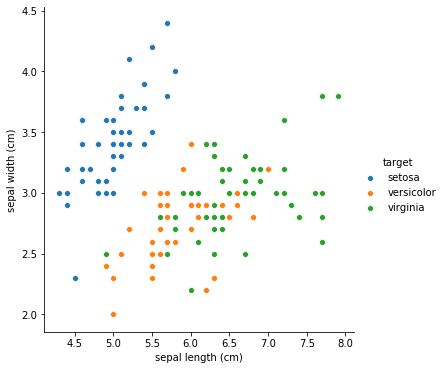

In [7]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target

iris_plot = pd.DataFrame(data=np.c_[iris['data'],iris['target']],columns = iris['feature_names']+['target'])
iris_plot['target'] = iris_plot['target'].map({0:"setosa", 1:"versicolor",2:"virginia"})

sns.pairplot(iris_plot,x_vars=["sepal length (cm)"],y_vars=["sepal width (cm)"],hue='target', size = 5)

IRIS data의 species Classification example.

종속 변수(species) : 3 class
독립 변수(sepal width, sepal length) : 2 variables

### Model & Hyper-parameter

Model: Random Forest

Hyper-parameter: n_estimator / max_depth

Criterion : Accuracy

In [9]:
import plotly.graph_objects as go

def sample_loss(params):
    return cross_val_score(RandomForestClassifier(random_state=0, n_estimators=int(params[0]), max_depth=int(params[1])),
                            X, y, scoring='accuracy', cv=3).mean()

n_estimators = np.linspace(1, 50, 50)
max_depths = np.linspace(1, 50, 50)

# We need the cartesian combination of these two vectors
param_grid = np.array([[n_estimator, max_depth] for max_depth in max_depths for n_estimator in n_estimators])
real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

param = pd.DataFrame(param_grid)
colorscale = [[0, 'grey'], [0.5, 'yellow'], [1, 'red']]
fig = go.Figure(data =
    go.Contour(
        z=real_loss,
        x=param[0],
        y=param[1],
        colorscale=colorscale
    ))
fig.show()
print("Maximum point is :", param_grid[np.array(real_loss).argmax(), :])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\JYW\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b309c389d7fb>", line 12, in <module>
    real_loss = [sample_loss(params) for params in param_grid]
  File "<ipython-input-9-b309c389d7fb>", line 12, in <listcomp>
    real_loss = [sample_loss(params) for params in param_grid]
  File "<ipython-input-9-b309c389d7fb>", line 5, in sample_loss
    X, y, scoring='accuracy', cv=3).mean()
  File "C:\Users\JYW\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 390, in cross_val_score
    error_score=error_score)
  File "C:\Users\JYW\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 236, in cross_validate
    for train, test in cv.split(X, y, groups))
  File "C:\Users\JYW\Anaconda3\lib\site-packages\joblib\parallel.py", line 1007, in __call__
    while self.dispatch_one_batch(itera

KeyboardInterrupt: 

Accuracy 기준으로 한 hyper-parameter의 Loss function

- - -
## 3. Bayesian optimization - Entropy Search

Iteration: 0


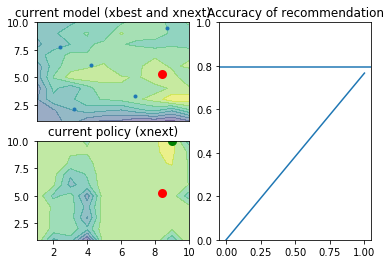

Iteration: 1


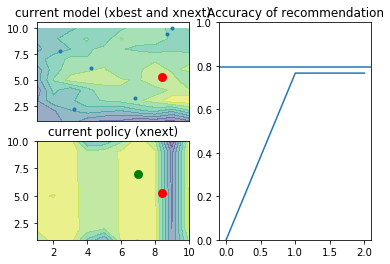

Iteration: 2


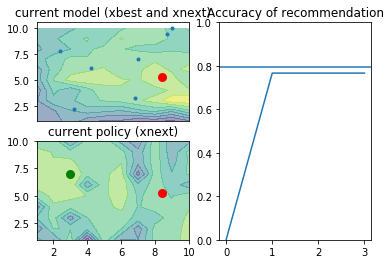

Iteration: 3


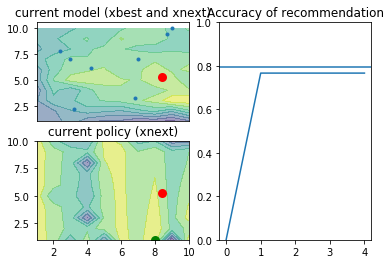

Iteration: 4


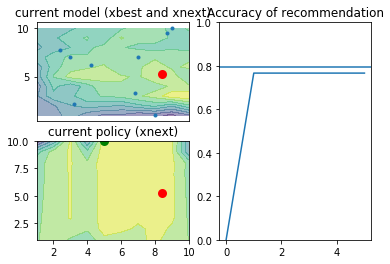

Iteration: 5


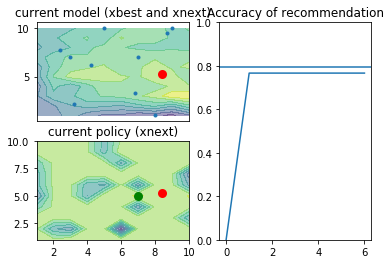

Iteration: 6


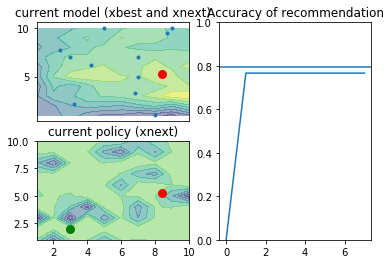

Iteration: 7


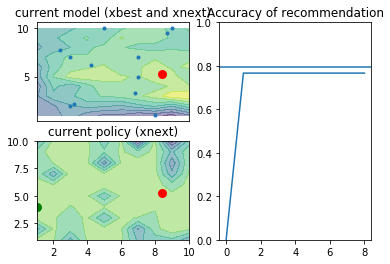

Iteration: 8


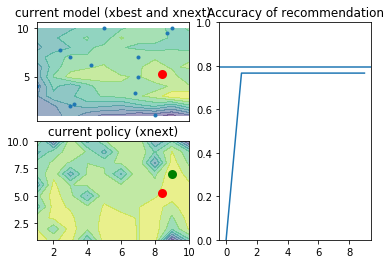

Iteration: 9


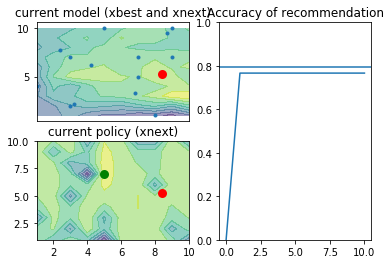

Iteration: 10


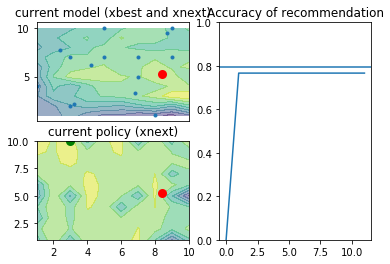

Iteration: 11


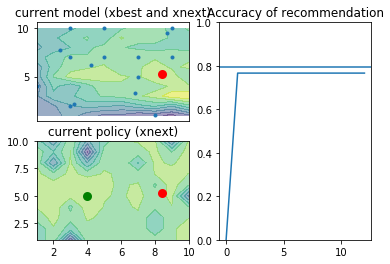

Iteration: 12


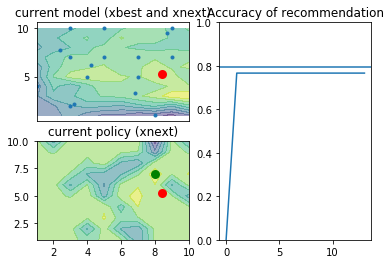

Iteration: 13


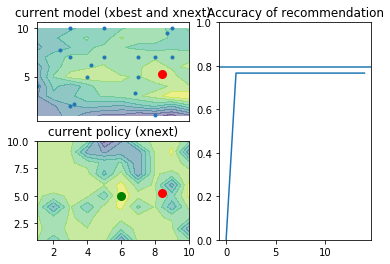

Iteration: 14


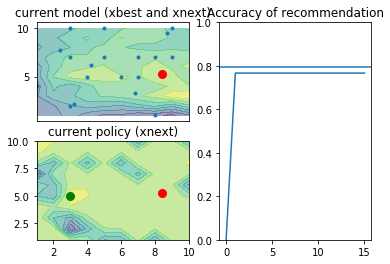

Iteration: 15


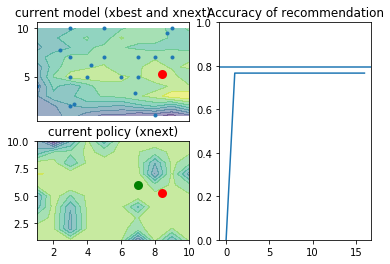

Iteration: 16


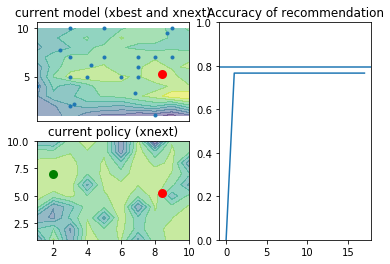

Iteration: 17


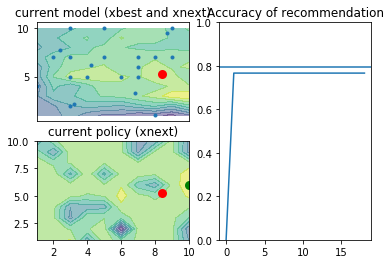

Iteration: 18


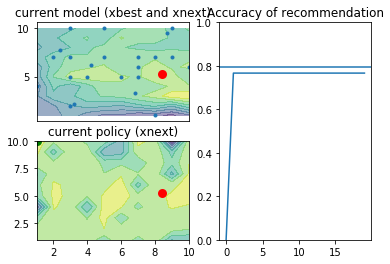

Iteration: 19


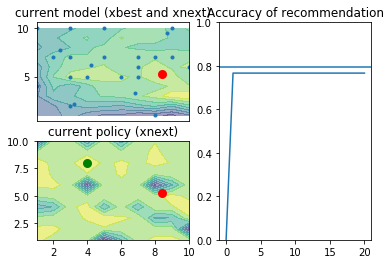

In [64]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import reggie as rg
from reggie import models
from matplotlib import pyplot as ez

from pybo.bayesopt import IndexPolicy, RecPolicy
from pybo.domains import Grid

__all__ = []

bounds = [[1, 10],[1, 10]]
xopt = [9, 3]
fopt = 0.7933333333333333

def init(self, method='latin', rng=None, **kwargs):
        return continuous.INITS[method](self.bounds, rng=rng, **kwargs)

domain = Grid(bounds, 10)
Xs = list(domain.init())
Y = [sample_loss(params) for params in Xs]
F = list()
F.append(0)

# policy choices: PI, EI, UCB, Thompson, PES, IPES
policy_name = 'PES'

# pybo.policies simple.py 에 계산식 있음.
if policy_name == 'PES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': False})
elif policy_name == 'IPES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': True})
else:
    policy = IndexPolicy(domain, policy_name)

# pybo recommenders.py 에 계산식 있음.
recommender = RecPolicy(domain, 'observed')

# initialize the model
model = models.make_gp(0.01, 1.9, [0.1, 0.1], 0)

# set the priors and make the model sample over hyperparameters
model.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model.params['mean']['bias'].prior = rg.core.priors.Normal(0, 20)

# make a meta-model to sample over models; add data
model = models.MCMC(model, n=20, skip=True)

model.add_data(Xs, Y)

fig = ez.figure()

n_iters = 10
for i in range(n_iters):
    print('Iteration: ' + str(i))
    # get the recommendation and the next query
    xbest = recommender(model, Xs, Y)
    xnext = policy(model, Xs)
    ynext = cross_val_score(RandomForestClassifier(random_state=0, n_estimators=int(xnext[0]), max_depth=int(xnext[1])),X, y, scoring='accuracy', cv=3).mean()

    # record our data and update the model
    Xs.append(xnext)
    Y.append(ynext)
    F.append(cross_val_score(RandomForestClassifier(random_state=0, n_estimators=int(xbest[0]), max_depth=int(xbest[1])),X, y, scoring='accuracy', cv=3).mean())
    model.add_data(xnext, ynext)

    # PLOT EVERYTHING
    fig.clear()
    ax1 = ez.subplot2grid((2, 2), (0, 0))
    ax2 = ez.subplot2grid((2, 2), (1, 0), sharex=ax1)
    ax3 = ez.subplot2grid((2, 2), (0, 1), rowspan=2)
    ax1.get_xaxis().set_visible(False)

    # plot the posterior and data
    X1, X2 = np.meshgrid(n_estimators, max_depths)
    Xs_ = np.array(Xs)

    ax1.contourf(X1, X2, np.array(real_loss).reshape(X1.shape), alpha=0.5)
    ax1.scatter(Xs_[:-1, 0],Xs_[:-1, 1], marker='.')
    ax1.scatter(xbest[0], xbest[1], linewidths=3, marker='o', color='r')
    ax1.set_title('current model (xbest and xnext)')

   # plot the acquisition function
    ax2.contourf(X1, X2, policy._index(domain.X).reshape(X1.shape), alpha=0.5)
    ax2.scatter(xbest[0], xbest[1], linewidths=3, marker='o', color='r')
    ax2.scatter(xnext[0], xnext[1], linewidths=3, marker='o', color='g')
    ax2.set_xlim(*bounds[0])
    ax2.set_ylim(*bounds[1])
    ax2.set_title('current policy (xnext)')

    # plot the latent function at recomended points
    ax3.axhline(fopt)
    ax3.plot(F)
    ax3.set_ylim(0., 1)
    ax3.set_title('Accuracy of recommendation')

    # draw
    fig.canvas.draw()
    ez.show(block=False)

Bayesian optimization은 Surrogate Model과 Acquisition Function를 도구로, Bayes inference를 통해 최적의 parameter 조합을 탐색한다.

In [67]:
print("Best parameter of Entropy Search:" "\n", "n_estimators:",int(xbest[0]),"\n","max_depth:",int(xbest[1]))

Best parameter of Entropy Search:
 n_estimators: 8 
 max_depth: 5


최적 값으로 찾은 것은 8, 5이다.

Accuracy: 0.77 (+/- 0.02) [Entropy Search]


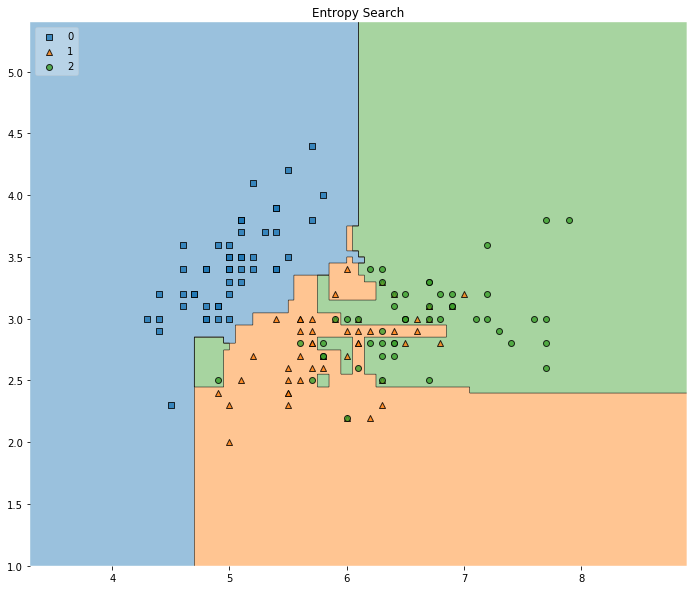

In [68]:
## fitting
clf_ES = RandomForestClassifier(random_state=0, n_estimators=8, max_depth=5)

label = ['Entropy Search']
clf_list = [clf_ES]

fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 3)
grid = itertools.product([0,1,2],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

최종 Accuracy는 0.77로 Randomized Search보다 0.02의 Accuracy 증가를 알 수 있다.

# 4. Simple Entropy approach

In [160]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import reggie as rg
from reggie import models
from matplotlib import pyplot as ez

from pybo.bayesopt import IndexPolicy, RecPolicy
from pybo.domains import Grid

__all__ = []

bounds = [[1, 10],[1, 10]]
xopt = [9, 3]
fopt = 0.7933333333333333

def init(self, method='latin', rng=None, **kwargs):
        return continuous.INITS[method](self.bounds, rng=rng, **kwargs)

domain = Grid(bounds, 10)
Xs = list(domain.init())
Y = [sample_loss(params) for params in Xs]
F = list()
F.append(0)

# initialize the model
model = models.make_gp(0.01, 1.9, [0.1, 0.1], 0)

# set the priors and make the model sample over hyperparameters
model.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model.params['mean']['bias'].prior = rg.core.priors.Normal(0, 20)

# make a meta-model to sample over models; add data
model = models.MCMC(model, n=20, skip=True)

model.add_data(Xs, Y)

Iteration: 0
Number of maximum entropy:  73


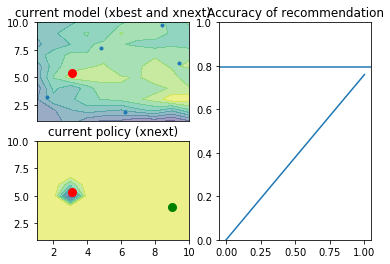

Iteration: 1
Number of maximum entropy:  81


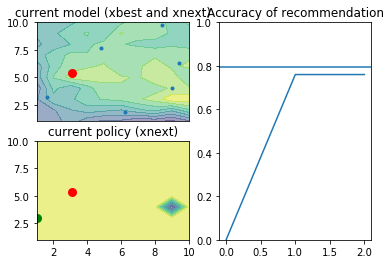

Iteration: 2
Number of maximum entropy:  89


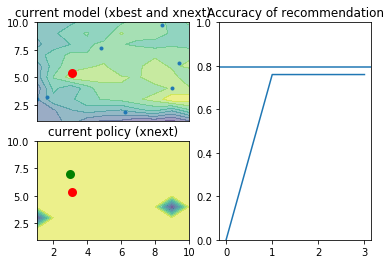

Iteration: 3
Number of maximum entropy:  15


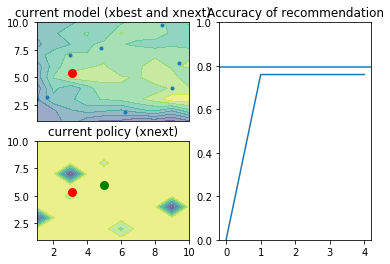

Iteration: 4
Number of maximum entropy:  1


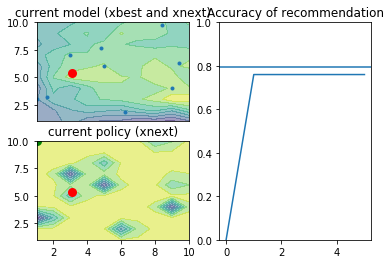

Iteration: 5
Number of maximum entropy:  1


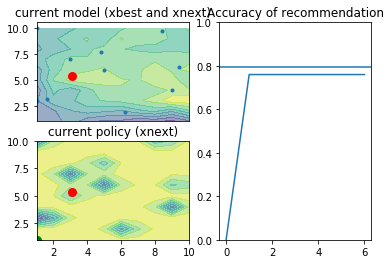

Iteration: 6
Number of maximum entropy:  1


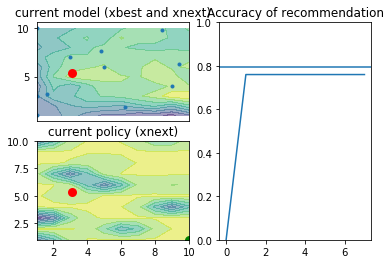

Iteration: 7
Number of maximum entropy:  1


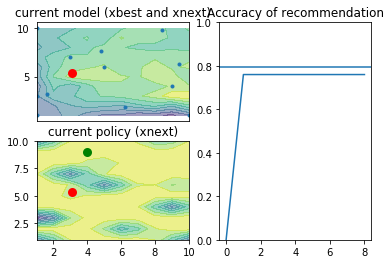

Iteration: 8
Number of maximum entropy:  1


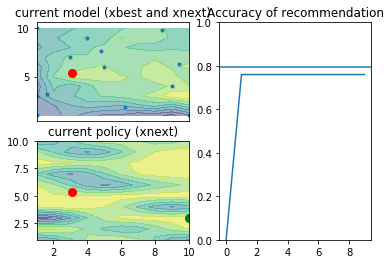

Iteration: 9
Number of maximum entropy:  1


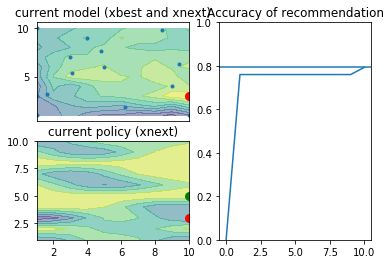

Iteration: 10
Number of maximum entropy:  1


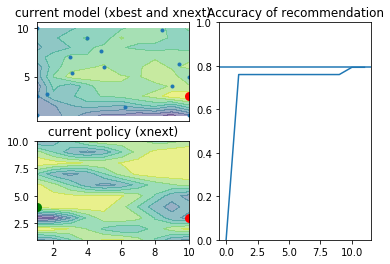

Iteration: 11
Number of maximum entropy:  1


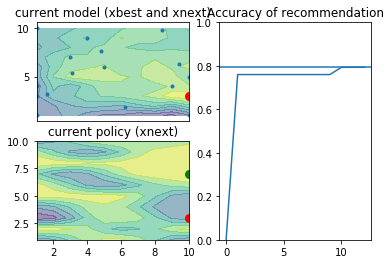

Iteration: 12
Number of maximum entropy:  1


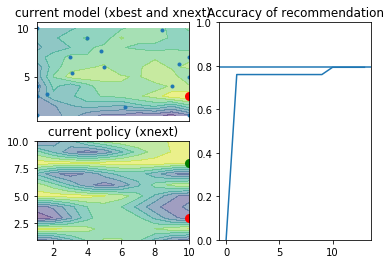

Iteration: 13
Number of maximum entropy:  1


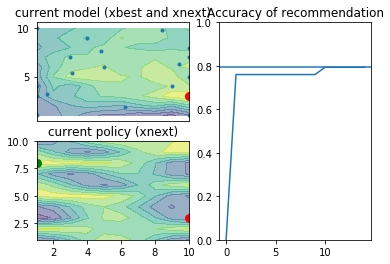

Iteration: 14
Number of maximum entropy:  1


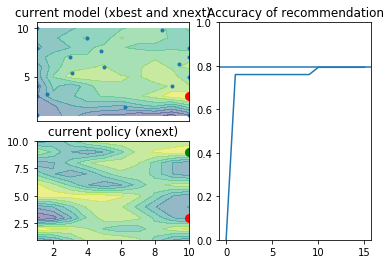

Iteration: 15
Number of maximum entropy:  1


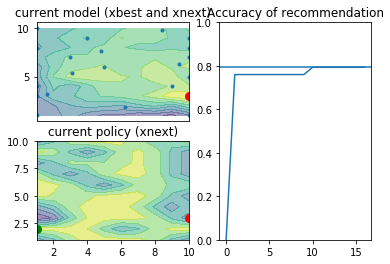

Iteration: 16
Number of maximum entropy:  1


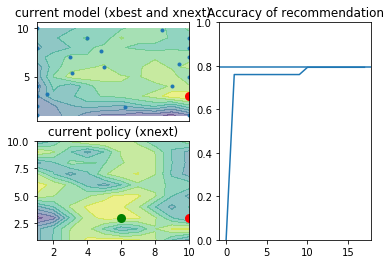

Iteration: 17
Number of maximum entropy:  1


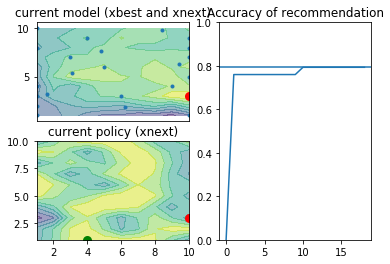

Iteration: 18
Number of maximum entropy:  1


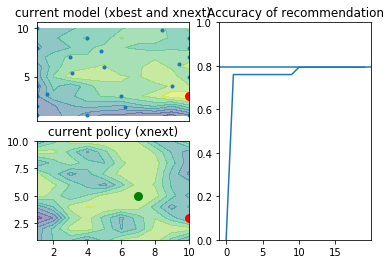

Iteration: 19
Number of maximum entropy:  1


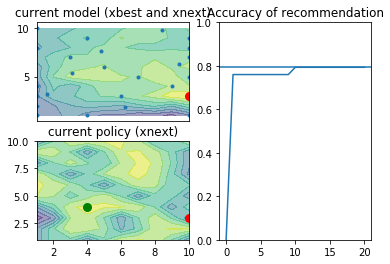

In [161]:
fig = ez.figure()

n_iters = 20
for i in range(n_iters):
    print('Iteration: ' + str(i))

    # plot the posterior and data
    X1, X2 = np.meshgrid(n_estimators, max_depths)
    Xs_ = np.array(Xs)
    
    candi = model.get_entropy(domain.X).reshape(X1.shape)
    
    print('Number of maximum entropy: ', str(len(np.where(candi == candi.max())[0])))
    
    if len(np.where(candi == candi.max())[0])==1 : 
        # get the recommendation and the next query
        xbest = Xs[Y.index(np.max(Y))]
        xnext = domain.X[candi.argmax()]
        ynext = cross_val_score(RandomForestClassifier(random_state=0, n_estimators=int(xnext[0]), max_depth=int(xnext[1])),X, y, scoring='accuracy', cv=3).mean()

    else :
        random_num = randint(0, len(np.where(candi == candi.max())[0]))

        # get the recommendation and the next query
        xbest = Xs[Y.index(np.max(Y))]
        xnext = np.array([(np.where(candi == candi.max())[0][random_num-1]+1),(np.where(candi == candi.max())[1][random_num-1]+1)]) 
        ynext = cross_val_score(RandomForestClassifier(random_state=0, n_estimators=int(xnext[0]), max_depth=int(xnext[1])),X, y, scoring='accuracy', cv=3).mean()
    
    Xs.append(xnext)
    Y.append(ynext)
    F.append(cross_val_score(RandomForestClassifier(random_state=0, n_estimators=int(xbest[0]), max_depth=int(xbest[1])),X, y, scoring='accuracy', cv=3).mean())
    
    # plot the posterior and data
    X1, X2 = np.meshgrid(n_estimators, max_depths)
    Xs_ = np.array(Xs)
    
    # PLOT EVERYTHING
    fig.clear()
    ax1 = ez.subplot2grid((2, 2), (0, 0))
    ax2 = ez.subplot2grid((2, 2), (1, 0), sharex=ax1)
    ax3 = ez.subplot2grid((2, 2), (0, 1), rowspan=2)
    ax1.get_xaxis().set_visible(False)


    ax1.contourf(X1, X2, np.array(real_loss).reshape(X1.shape), alpha=0.5)
    ax1.scatter(Xs_[:-1, 0],Xs_[:-1, 1], marker='.')
    ax1.scatter(xbest[0], xbest[1], linewidths=3, marker='o', color='r')
    ax1.set_title('current model (xbest and xnext)')

    # plot the acquisition function
    ax2.contourf(X1, X2, model.get_entropy(domain.X).reshape(X1.shape), alpha=0.5)
    ax2.scatter(xbest[0], xbest[1], linewidths=3, marker='o', color='r')
    ax2.scatter(xnext[0], xnext[1], linewidths=3, marker='o', color='g')
    ax2.set_xlim(*bounds[0])
    ax2.set_ylim(*bounds[1])
    ax2.set_title('current policy (xnext)')

    # plot the latent function at recomended points
    ax3.axhline(fopt)
    ax3.plot(F)
    ax3.set_ylim(0., 1)
    ax3.set_title('Accuracy of recommendation')

    # record our data and update the model
    model.add_data(xnext, ynext)
    
    # draw
    fig.canvas.draw()
    ez.show(block=False)

In [162]:
Xs_grid = Xs
real_loss = [sample_loss(grid) for grid in Xs_grid]

# The maximum is at:
Xs_grid[np.array(real_loss).argmax()]

grid = pd.DataFrame(Xs_grid)
colorscale = [[0, 'grey'], [0.5, 'yellow'], [1, 'red']]
fig = go.Figure(data =
    go.Contour(
        z=real_loss,
        x=grid[0],
        y=grid[1],
        colorscale=colorscale
    ))
fig.show()
print("Maximum point is :", Xs_grid[np.array(real_loss).argmax()])

Maximum point is : [10.  3.]
